In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import scipy.optimize as opt
from scipy.optimize import curve_fit
import spinmob as s
import matplotlib.pylab as pylab

In [108]:
def linear(V, m, b):
    return m*V + b

In [109]:
mv = (np.loadtxt('all_the_mv.csv', delimiter=',', skiprows = 1))

In [110]:
result = []
for sublist in mv:
    for item in sublist:
        result.append(item)
#print("\nCollapse nested lists:")
final_result = np.transpose(result)
# print(final_result)

TempArray = np.linspace(-270, 399, 670)

### Temp vs Voltage

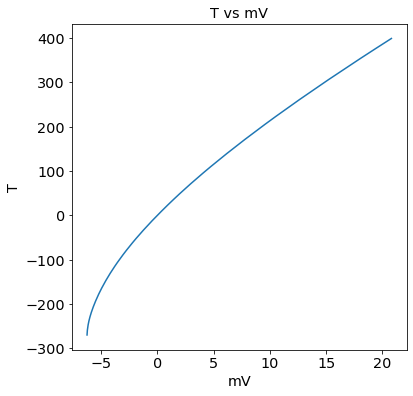

In [111]:
plt.plot(final_result, TempArray)
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.show()

### Trying with just taking linear approx on small scales

In [112]:
#splitting arrays in to 10 element arrays
mVArraysOf10 = np.split(final_result, len(final_result)/10)
TArraysOf10 = np.split(TempArray, len(final_result)/10)

for i in range(0, len(mVArraysOf10)):
    if (i != len(mVArraysOf10) - 1):
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i+1][0])
        TArraysOf10[i] = np.append(TArraysOf10[i], TArraysOf10[i+1][0])

    else:
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i-1][-1])
        TArraysOf10[i]= np.append(TArraysOf10[i], TArraysOf10[i-1][-1])


#get linear fit for each array of 10
fits = []

for i in range(0, int(len(final_result)/10)):
    popt, pcov = curve_fit(linear, mVArraysOf10[i], TArraysOf10[i])
    fits.append([popt, np.sqrt(np.diag(pcov))])
    
# print(fits[-1])
# perr = np.sqrt(np.diag(fits[0][0]))
# print(perr)

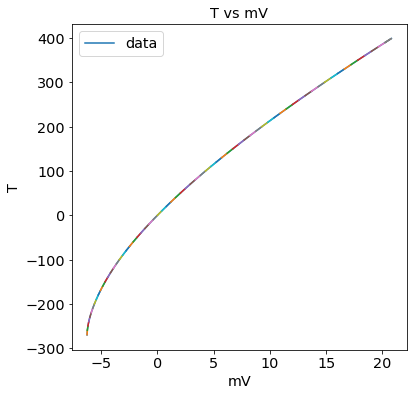

In [113]:
#plotting fits to make sure they match the data

plt.plot(final_result, TempArray, label="data")
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.legend()

for i in range(0, len(fits)):
    plt.plot(mVArraysOf10[i], linear(mVArraysOf10[i], fits[i][0][0], fits[i][0][1]))

plt.show()

## Errors
#### From Temp calibration  
LIMITS OF ERROR (whichever is greater)			
Standard	1.0Â°C or 0.75% Above 0Â°C	 1.0Â°C or 1.5% Below 0Â°C	
Special	0.5Â°C or 0.4%		
lets go with 1 degree for now

#### Model 199 DMM
0.0012(value) + 3^3 in last digit

In [172]:

"""
Takes input voltage (mV) and outputs corresponding temperature (C)
Must be run with mVArraysOf10[] and fits[]
Need errors


"""
def getTempFromVolt(V):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1])
            fitted = True

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            break
    
    return TempVal

def linearErr(V, erV, m, erM, b, erb):
    return np.sqrt( (m*V)**2*( (erM/m)**2+ (erV/V)**2) + (erb)**2 )

"""
Takes in a voltage and it's error.
Returns an array of the corresponding temp in kelvin and it's error
"""
def getTempFromVolt_Err(V, ErrV):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1]) + 273.15
            fitted = True
            
            Err = linearErr(V, ErrV, fits[index][0][0], fits[index][1][0], fits[index][0][1], fits[index][1][1])
            #need to get errors
#             fits[index][1][0], fits[index][1][1] + error on V

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            Err = 0
            break
    
    return [TempVal, Err]

def ErrOnVoltage(data):
    errStatic = 3**3*(1e-7)
    Err = []

    for row in data:
        row_err = []
        for ele in row:
            row_err.append(0.012*ele + errStatic) 

        Err.append(row_err)
        
    return np.array(Err)

In [183]:
# Use function to get temp for a given V
V = -3.61
VoltErr = 0.012*V + 3**3*(1e-7) #this is sorta for the wrong range

Temp = getTempFromVolt_Err(V, VoltErr)
            
print("%f (%f) K" %(Temp[0], Temp[1]))

164.855995 (1.584915) K


### Data from max angle - heating up

In [174]:
# tempdataM_T_maxA  = [getTempFromVolt(V) for V in dataM_T_maxA[7]*1e3]

In [175]:
# peak = np.where(tempdataMandT == np.amax(tempdataMandT))[0][0]
# tempdataMandT = tempdataMandT[0:peak]
# dataMandT = dataMandT[:, 0:peak]

# print(len(dataMandT))

# plt.plot(tempdataMandT, ls=" ", marker=".")

# plt.grid()
# plt.xlabel("timeish")
# plt.ylabel("Temperature [C]")

# plt.show()

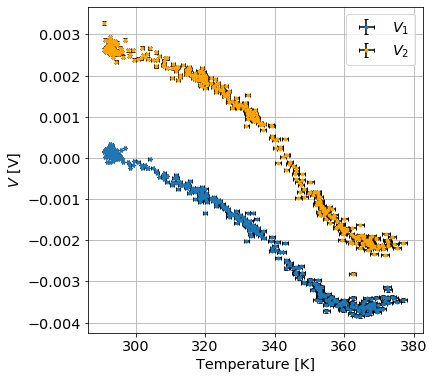

In [192]:
dataM_T_maxA = np.transpose((np.loadtxt('Data/2020-02-14 15_26 Voltage Readings Data_full.csv', delimiter=',', skiprows = 1)))

Err_M_T_maxA = ErrOnVoltage(dataM_T_maxA)

TempErr_M_T_maxA = [getTempFromVolt_Err(dataM_T_maxA[7][i]*1e3, Err_M_T_maxA[7][i]*1e3) for i in range(0, len(dataM_T_maxA[0])) ]
TempErr_M_T_maxA = np.transpose(TempErr_M_T_maxA)

plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[0], yerr=Err_M_T_maxA[0], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[1], yerr=Err_M_T_maxA[1], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()

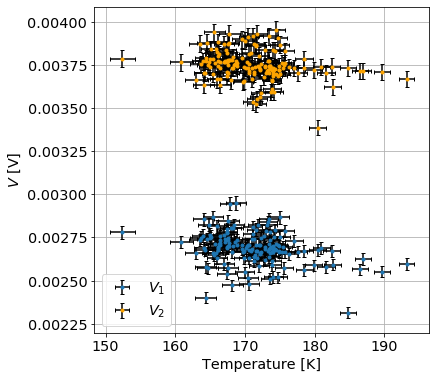

In [204]:
dataM_T_maxA = np.transpose((np.loadtxt('Data/2020-02-19 14_49 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))

Err_M_T_maxA = ErrOnVoltage(dataM_T_maxA)

TempErr_M_T_maxA = [getTempFromVolt_Err(dataM_T_maxA[7][i]*1e3, Err_M_T_maxA[7][i]*1e3) for i in range(0, len(dataM_T_maxA[0])) ]
TempErr_M_T_maxA = np.transpose(TempErr_M_T_maxA)

# plt.plot(TempErr_M_T_maxA[0][100:], ls=" ", marker=".")
# plt.grid()
# plt.xlabel("timeish")
# plt.ylabel("Temperature [C]")

plt.show()

#Cutting first part of data as it was taken while ajustments were made
dataM_T_maxA = dataM_T_maxA[:, 100:]
Err_M_T_maxA = Err_M_T_maxA[:,100:]
TempErr_M_T_maxA = TempErr_M_T_maxA[:, 100:]

plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[0], yerr=Err_M_T_maxA[0], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[1], yerr=Err_M_T_maxA[1], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()

### Data from min angle - full range

In [189]:
#we're gonna have to cut the top of this as we were making ajustmenets
dataM_T_minA = np.transpose((np.loadtxt('Data/2020-02-17 14_28 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))

#fixing temperature drop, just for this run
dataM_T_minA = np.concatenate((dataM_T_minA[:, 75:262], dataM_T_minA[:, 263:]), axis=1)
Err_M_T_minA = ErrOnVoltage(dataM_T_minA)

tempDataHigher = []

for i in range(0, len(dataHigher[7])):
    Temp = getTempFromVolt_Err(dataHigher[7][i]*1e3, Err_M_T_minA[7][i]*1e3)
    if (i<261):
        Temp[0] = Temp[0] + 21  
    tempDataHigher.append(Temp)

TempErr_M_T_minA = np.transpose(tempDataHigher)

# TempDataCom = tempDataHigher
# DataCom = dataHigher

# plt.plot(TempDataCom, ls=" ", marker=".")

# plt.grid()
# plt.xlabel("timeish")
# plt.ylabel("Temperature [C]")

# plt.show()

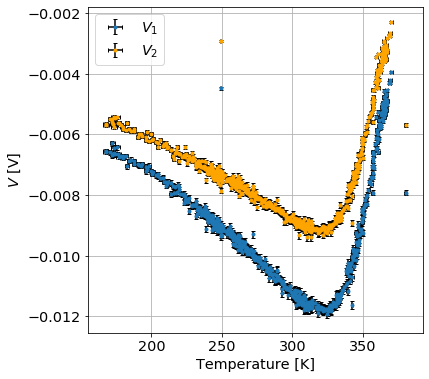

In [191]:
# DataCom_Err = ErrOnVoltage(DataCom)
    
plt.errorbar(TempErr_M_T_minA[0], dataM_T_minA[0], yerr=Err_M_T_minA[0], xerr=TempErr_M_T_minA[1], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempErr_M_T_minA[0], dataM_T_minA[1], yerr=Err_M_T_minA[1], xerr=TempErr_M_T_minA[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()